## California Housing Price
- predict median price per district
- model: regression/labeled supervised learning
- dataset: https://github.com/ageron/handson-ml2/tree/master/datasets/housing

### 1. Read Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

In [2]:
df=pd.read_csv("california_housing.csv")
df["median_house_value"]/= 1000 #scaling
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452.6,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358.5,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352.1,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341.3,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342.2,NEAR BAY


In [3]:
df.shape

(20640, 10)

In [32]:
df.isna().sum()
#total_badrooms 207/20640 is missing

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [5]:
df=df.dropna()

### 2. Data Exploration

In [33]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16573.000000,16573.000000,16573.000000,16573.000000,16573.000000,16573.000000,16573.000000,16573.000000,16573.000000
mean,-119.622771,35.719383,29.848851,2037.759006,420.726060,1124.572497,394.041634,3.583371,187.573197
std,2.005780,2.175011,12.219032,981.621732,196.160063,522.832209,182.447199,1.450085,95.465767
min,-124.350000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14.999000
25%,-121.800000,33.940000,20.000000,1339.000000,280.000000,747.000000,266.000000,2.489600,112.500000
50%,-118.740000,34.410000,31.000000,1914.000000,398.000000,1072.000000,375.000000,3.401500,170.000000
75%,-118.040000,37.750000,38.000000,2650.000000,545.000000,1475.000000,510.000000,4.505200,242.100000
max,-114.490000,41.950000,52.000000,4991.000000,999.000000,2500.000000,982.000000,8.000000,499.100000


#### Take away:
- comparing to 75%, max for `total_rooms`, `population`, `households` need a further check.
- abnormal data for target col `median_house_value`.

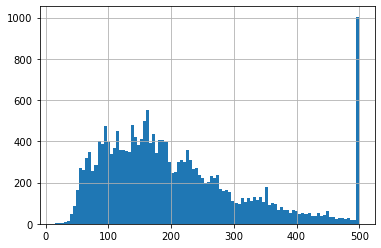

In [7]:
df.median_house_value.hist(bins=100)
#abnormal data here, outlier

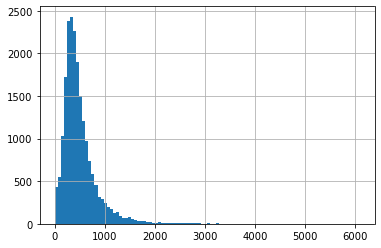

In [8]:
df.households.hist(bins=100)

In [ ]:
df=df[(df.total_rooms<=5000)&(df.total_bedrooms<=1000)&(df.population<=2500)&(df.households<=1000)&
      (df.median_income<=8)&(df.median_house_value<500)]

#df.median_house_value.hist(bins=100)
#df.total_bedrooms.hist(bins=100)
#df.median_income.hist(bins=100)
#df.total_rooms.hist(bins=100)
#df.population.hist(bins=100)
#df.households.hist(bins=100)
df.hist(bins=100,figsize=(15,10))
plt.show()

In [10]:
df.shape

(16573, 10)

In [11]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352.1,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341.3,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342.2,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269.7,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299.2,NEAR BAY


### 4. Modeling

### 4.0 Train/Test Split

In [39]:
from sklearn.model_selection import train_test_split
train, test= train_test_split(df,test_size=0.22, random_state=123)
print("Total Sample size: %i\n training size: %i \n test size: %i"\
%(df.shape[0],train.shape[0],test.shape[0]))

Total Sample size: 16573
 training size: 12926 
 test size: 3647


In [13]:
train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
373,-122.16,37.75,44.0,617.0,131.0,378.0,135.0,2.5568,111.1,NEAR BAY
18891,-122.23,38.11,47.0,3007.0,524.0,1152.0,486.0,4.0000,141.5,NEAR BAY
13484,-117.37,34.12,32.0,3190.0,568.0,1614.0,512.0,3.8398,118.2,INLAND
173,-122.25,37.80,43.0,2344.0,647.0,1710.0,644.0,1.6504,151.8,NEAR BAY
10052,-121.04,39.19,17.0,856.0,167.0,518.0,170.0,3.5859,144.3,INLAND


In [14]:
y_train=train['median_house_value']
y_train

373      111.1
18891    141.5
13484    118.2
173      151.8
10052    144.3
         ...  
106      268.5
16729    267.5
9539      72.7
19242    192.0
19635    125.0
Name: median_house_value, Length: 11103, dtype: float64

In [15]:
#train.drop('median_house_value',axis=1, inplace=True)
#X_train=train
#X_train.shape

### 4.1 Define functions that build and train a model
- build_model(learning_rate), which builds a randomly-initialized model.
- train_model(model, feature, label, epochs), which trains the model from the examples (feature and label) you pass.

In [49]:
#Define the functions that build and train a model
def build_model(learning_rate):
  """Create and compile a simple linear regression model."""
  model = tf.keras.models.Sequential() # Most simple tf.keras models are sequential.

  # Describe the topography of a model.
  model.add(tf.keras.layers.Dense(units=1, 
                                  input_shape=(2,))) # a single node in a single layer.

  # Compile the model that TensorFlow can efficientlyexecute. 
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model        

# Train the model by feeding the feature and the label.
# The model will train for the specified number of epochs. 
def train_model(model, df, feature, label, epochs, batch_size):
  history = model.fit(x=df[feature],
                      y=df[label],
                      batch_size=batch_size,
                      epochs=epochs)

  # Gather the trained model's weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # Isolate the error for each epoch.
  hist = pd.DataFrame(history.history)

  # take a snapshot of the model's root mean squared error at each epoch. 
  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse

### 4.2 Define plotting functions
- a scatter plot of the feature vs. the label, and a line showing the output of the trained model
- a loss curve

In [50]:
#Plot the trained model against 200 random training examples.
def plot_the_model(trained_weight, trained_bias, feature, label):
  plt.xlabel(feature)
  plt.ylabel(label)

  # Create a scatter plot from 200 random points of the dataset.
  random_examples = train.sample(n=200)
  plt.scatter(random_examples[feature], random_examples[label])

  # Create a red line representing the model. The red line starts
  # at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = 10000
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')
  plt.show()

# Plot a curve of loss vs. epoch.
def plot_the_loss_curve(epochs, rmse):
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()  

### 4.3 Call the model functions

In [51]:
train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
18633,-121.96,37.06,16.0,1321.0,224.0,650.0,206.0,6.3258,390.0,NEAR OCEAN
4417,-118.26,34.08,45.0,2174.0,627.0,1992.0,557.0,2.5428,167.8,<1H OCEAN
2250,-119.80,36.80,43.0,1951.0,288.0,725.0,308.0,6.3359,169.3,INLAND
2391,-119.33,36.89,15.0,1879.0,411.0,755.0,294.0,2.0000,83.3,INLAND
12802,-121.44,38.61,33.0,1591.0,466.0,1000.0,418.0,1.0467,70.1,INLAND


In [ ]:
train.columns.values

In [52]:
# Hyperparameters:
learning_rate = 0.01
epochs = 100
batch_size = 30

my_feature = ['longitude','latitude']
my_label= 'median_house_value'

# Discard any pre-existing version of the model.
my_model = None

# Invoke the functions.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, train, 
                                         my_feature, my_label,
                                         epochs, batch_size)

print("\nThe learned weight for your model is %.4f" % weight)
print("The learned bias for your model is %.4f\n" % bias )

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

Epoch 1/100
431/431 [==============================] - 1s 813us/step - loss: 13811.3781 - root_mean_squared_error: 116.1628
Epoch 2/100
431/431 [==============================] - 0s 1ms/step - loss: 9229.0882 - root_mean_squared_error: 96.0635
Epoch 3/100
431/431 [==============================] - 0s 880us/step - loss: 9316.7668 - root_mean_squared_error: 96.5205
Epoch 4/100
431/431 [==============================] - 0s 865us/step - loss: 9110.4475 - root_mean_squared_error: 95.4306
Epoch 5/100
431/431 [==============================] - 0s 872us/step - loss: 9039.2424 - root_mean_squared_error: 95.0713
Epoch 6/100
431/431 [==============================] - 0s 833us/step - loss: 9158.9397 - root_mean_squared_error: 95.6992
Epoch 7/100
431/431 [==============================] - 0s 882us/step - loss: 9383.5614 - root_mean_squared_error: 96.8600
Epoch 8/100
431/431 [==============================] - 0s 898us/step - loss: 9342.7948 - root_mean_squared_error: 96.6368
Epoch 9/100
431/431 [===

431/431 [==============================] - 0s 859us/step - loss: 8787.9243 - root_mean_squared_error: 93.7383
Epoch 67/100
431/431 [==============================] - 0s 840us/step - loss: 8799.6051 - root_mean_squared_error: 93.8036
Epoch 68/100
431/431 [==============================] - 0s 949us/step - loss: 8661.2922 - root_mean_squared_error: 93.0552
Epoch 69/100
431/431 [==============================] - 0s 908us/step - loss: 8408.7349 - root_mean_squared_error: 91.6917
Epoch 70/100
431/431 [==============================] - 0s 880us/step - loss: 8591.3035 - root_mean_squared_error: 92.6817
Epoch 71/100
431/431 [==============================] - 0s 1ms/step - loss: 8794.7481 - root_mean_squared_error: 93.7769
Epoch 72/100
431/431 [==============================] - 0s 1ms/step - loss: 8772.2782 - root_mean_squared_error: 93.6553
Epoch 73/100
431/431 [==============================] - 0s 838us/step - loss: 8528.5164 - root_mean_squared_error: 92.3443
Epoch 74/100
431/431 [===========

TypeError: only size-1 arrays can be converted to Python scalars

### 4.4 Make predictions

In [30]:
#Predict house values.
def predict_house_values(n, feature, label):
    
  batch = train[feature][10000:10000 + n]
  y_predicted= my_model.predict_on_batch(x=batch)

  print("feature   label          predicted")
  print("  value   value          value")
  print("          in thousand$   in thousand$")
  print("--------------------------------------")
  for i in range(n):
    print ("%6.0f %6.0f %15.0f" % (train[feature][10000 + i],
                                   train[label][10000 + i],
                                   y_predicted[i][0] ))

In [31]:
#invoke the house prediction function on 10 examples:
predict_house_values(10, my_feature, my_label)

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
  1839    210             256
  1813    182             226


KeyError: 10002